In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data=pd.read_csv("/content/TimeSeries_TotalSolarGen_and_Load_IT_2016.csv")

In [10]:
data.head(5)

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


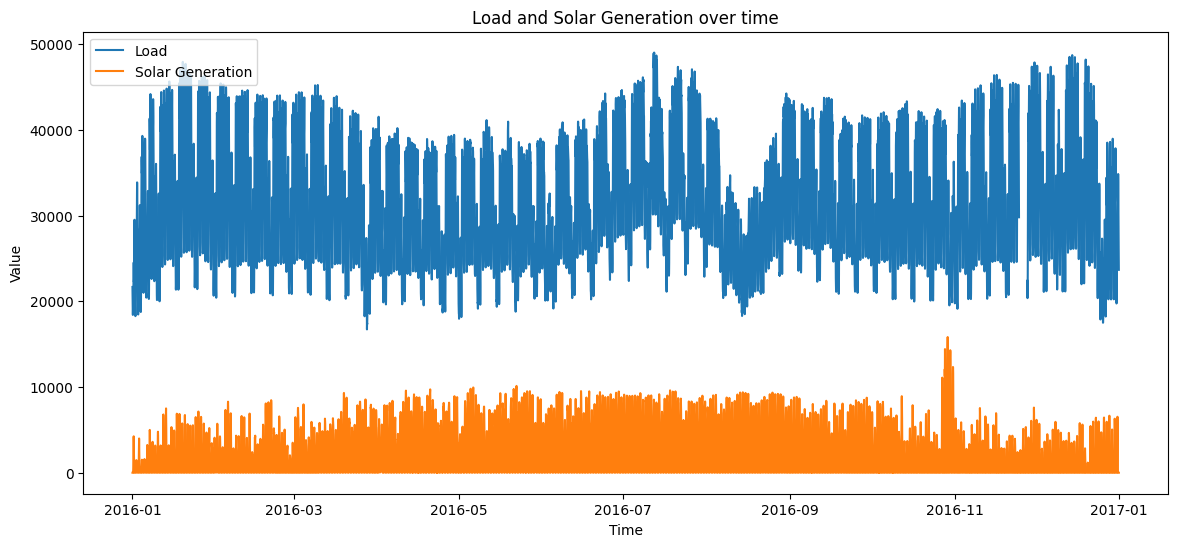

In [11]:
data['utc_timestamp']=pd.to_datetime(data["utc_timestamp"])
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'],data["IT_load_new"],label='Load')
plt.plot(data['utc_timestamp'],data["IT_solar_generation"],label='Solar Generation')
plt.xlabel('Time')
plt.ylabel("Value")
plt.legend()
plt.title('Load and Solar Generation over time')
plt.show()

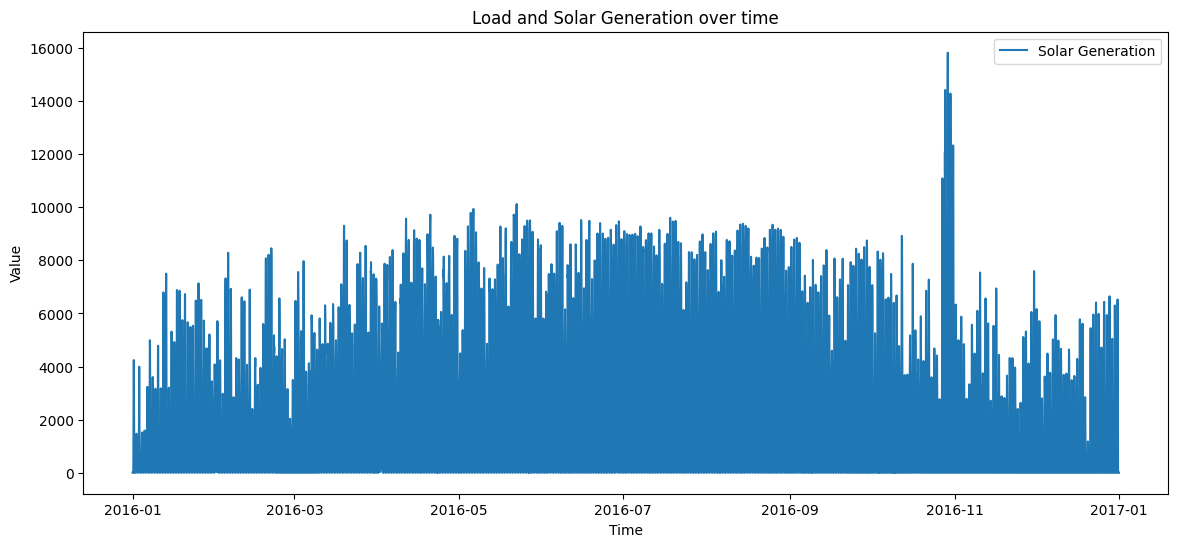

In [12]:
data['utc_timestamp']=pd.to_datetime(data["utc_timestamp"])
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'],data["IT_solar_generation"],label='Solar Generation')
plt.xlabel('Time')
plt.ylabel("Value")
plt.legend()
plt.title('Load and Solar Generation over time')
plt.show()

The plot shows both the load and solar generation over time for the year 2016. The load appears to have a cyclical pattern with peaks and valleys, possibly corresponding to daily patterns of electricity use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

Before moving on to time series analysis and forecasting with ARIMA, it's important to check for stationarity in your time series data. Stationarity is a property of time series data that implies the mean, variance, and autocorrelation structure do not change over time. Many time series models, including ARIMA, require the data to be stationary.

Let's perform an Augmented Dickey-Fuller test to check the stationarity of the time series. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

#Handling Missing Values


In [13]:
data.isnull().sum()

,0
utc_timestamp,0
IT_load_new,72
IT_solar_generation,0


In [14]:
# Fill missing values using forward fill
data['IT_load_new'].fillna(method='ffill', inplace=True)

# Check for missing values again
print("Missing values after filling:")
print(data.isnull().sum())

Missing values after filling:
utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64


/tmp/ipython-input-3163531581.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['IT_load_new'].fillna(method='ffill', inplace=True)
/tmp/ipython-input-3163531581.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new'].fillna(method='ffill', inplace=True)


In [15]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [16]:
# Perform Augmented Dickey-Fuller test again
print("\nADF test for 'IT_load_new' after filling missing values:")
adf_test(data['IT_load_new'])

print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])


ADF test for 'IT_load_new' after filling missing values:
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


In [17]:
# Perform test for 'IT_load_new'
print("ADF test for 'IT_load_new':")
adf_test(data['IT_load_new'])

# Perform test for 'IT_solar_generation'
print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])

ADF test for 'IT_load_new':
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


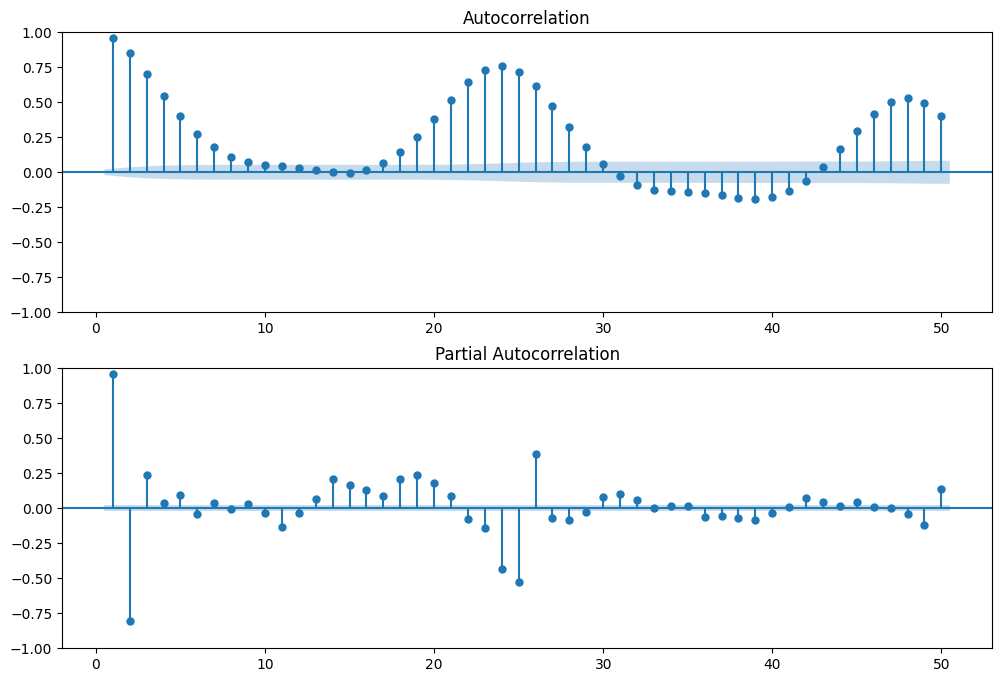

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_load_new'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_load_new'], lags=50, zero=False, ax=ax2)
plt.show()

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7714.95213482925

In [20]:
# Fit the ARIMA model
model2 = ARIMA(train, order=(2,1,2))
model_fit2 = model2.fit()

# Make predictions on the test set
predictions2 = model_fit2.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse2 = sqrt(mean_squared_error(test, predictions2))
rmse2

7993.84942771682

In [21]:
# Fit the ARIMA model
model3 = ARIMA(train, order=(2,2,2))
model_fit3 = model2.fit()

# Make predictions on the test set
predictions3 = model_fit3.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse3 = sqrt(mean_squared_error(test, predictions3))
rmse3

7993.84942771682

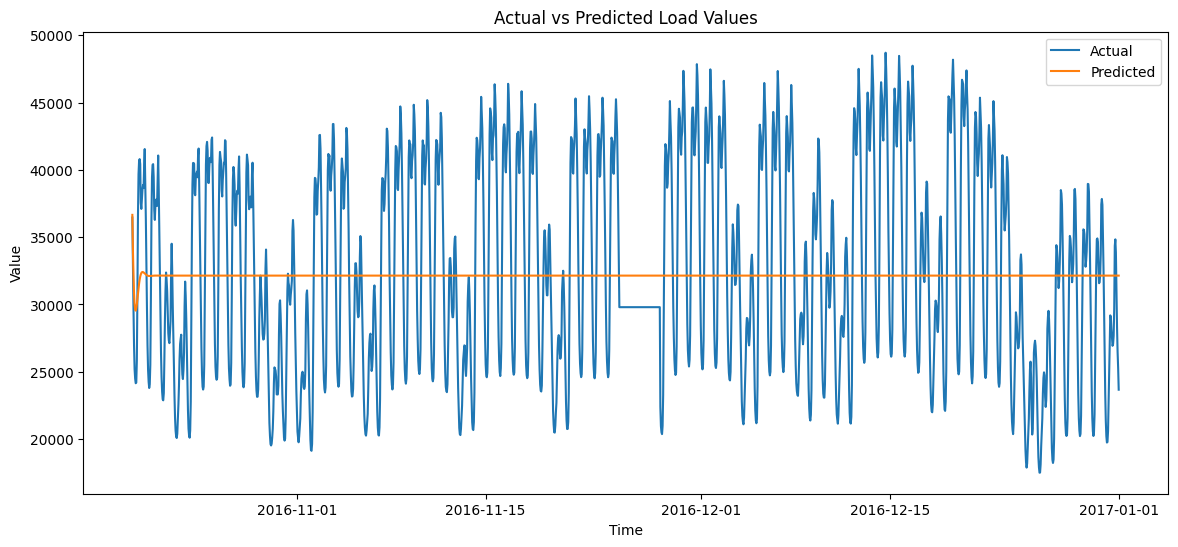

In [22]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

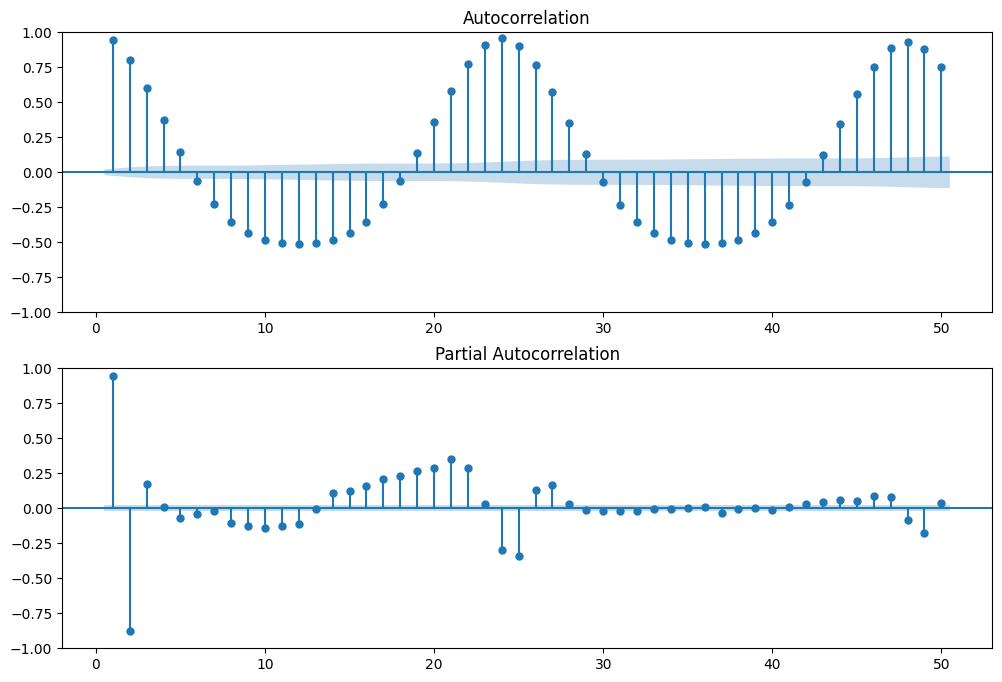

In [23]:
# Plot ACF and PACF for 'IT_solar_generation'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.1507110911857

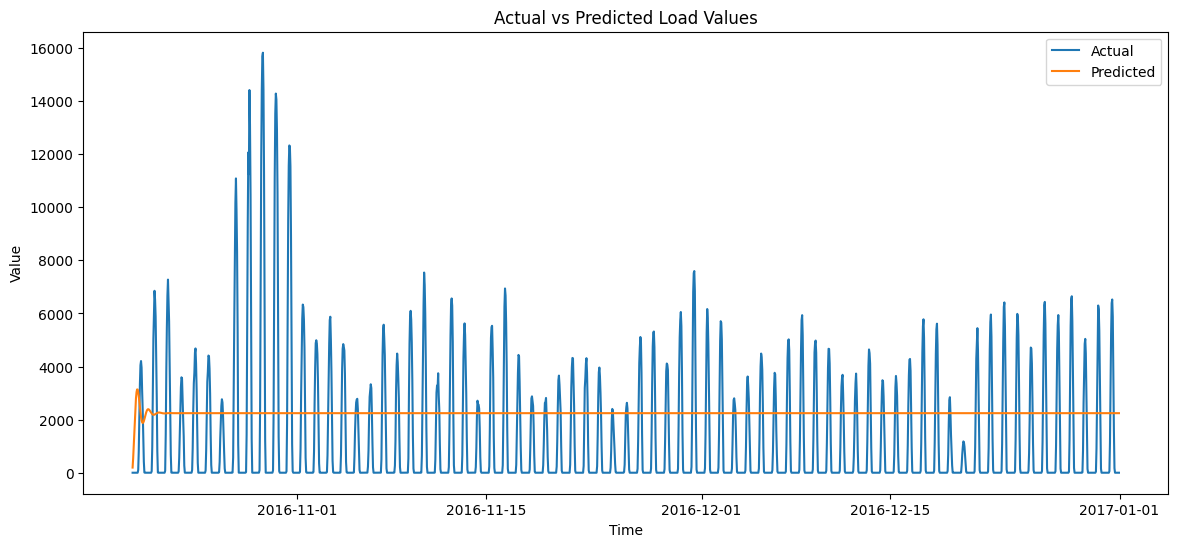

In [25]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()